# TensorFlow: Predict Fuel Efficiency Using Linear Regression

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [ ]:
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

import tensorflow as tf

print("TF Version: ", tf.__version__)
print("TF Eager mode: ", tf.executing_eagerly())
print("TF GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

# Prepare Dataset

## Load dataset

In [153]:
url = "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data"

column_names = [
    "MPG",
    "Cylinders",
    "Displacement",
    "Horsepower",
    "Weight",
    "Acceleration",
    "Model Year",
    "Origin"
]

# Download and parse data in CSV format
raw_dataset = pd.read_csv(
    url,
    names=column_names,
    na_values='?',
    comment='\t',
    sep=' ',
    skipinitialspace=True)

In [154]:
dataset = raw_dataset.copy()
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


## Clean dataset

In [155]:
# Drop rows with missing values
dataset = dataset.dropna()

In [156]:
# Map categorical origin value to certain string
dataset["Origin"] = dataset["Origin"].map({1: "USA", 2: "Europe", 3: "Japan"})
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,USA
394,44.0,4,97.0,52.0,2130.0,24.6,82,Europe
395,32.0,4,135.0,84.0,2295.0,11.6,82,USA
396,28.0,4,120.0,79.0,2625.0,18.6,82,USA
397,31.0,4,119.0,82.0,2720.0,19.4,82,USA


In [157]:
# Convert origin string value into indicator columns (Origin -> Europe|Japan|USA with true/false value)
dataset = pd.get_dummies(
    dataset,
    columns=["Origin"],
    prefix="",
    prefix_sep="",
    dtype="float")
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
393,27.0,4,140.0,86.0,2790.0,15.6,82,0.0,0.0,1.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,1.0,0.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,0.0,0.0,1.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,0.0,0.0,1.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,0.0,0.0,1.0


## Split dataset

In [158]:
train_ds = dataset.sample(frac=0.8, random_state=0)
test_ds = dataset.drop(train_ds.index)

In [159]:
train_ds.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


In [160]:
# Train features
train_features = train_ds.copy()
test_features = test_ds.copy()

# Target values
train_labels = train_features.pop("MPG")
test_labels = test_features.pop("MPG")

In [161]:
train_features.tail()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
281,6,200.0,85.0,2990.0,18.2,79,0.0,0.0,1.0
229,8,400.0,180.0,4220.0,11.1,77,0.0,0.0,1.0
150,4,108.0,93.0,2391.0,15.5,74,0.0,1.0,0.0
145,4,83.0,61.0,2003.0,19.0,74,0.0,1.0,0.0
182,4,107.0,86.0,2464.0,15.5,76,1.0,0.0,0.0


## Normalizers

In [162]:
# Create and adapt normalizer for all columns
normalizer = tf.keras.layers.Normalization(axis=-1)
normalizer.adapt(np.array(train_features))

In [163]:
# Create and adapt normalizer for "Horsepower" column
horsepower_normalizer = tf.keras.layers.Normalization(axis=None)
horsepower_normalizer.adapt(np.array(train_features["Horsepower"]))

# Linear regression

In [190]:
def plot_loss(history):
  plt.plot(history.history["loss"], label="Loss")
  plt.plot(history.history["val_loss"], label="Validation Loss")
  plt.ylim([0, 10])
  plt.xlabel("Epoch")
  plt.ylabel("Error [MPG]")
  plt.legend()
  plt.grid(True)

## Linear regression with one variable

In [164]:
# Select horsepower feature
horsepower = train_features["Horsepower"]

In [165]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    tf.keras.layers.Dense(1),
])

In [166]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss="mean_absolute_error")

In [167]:
%%time
history = horsepower_model.fit(
    train_features["Horsepower"],
    train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

CPU times: user 4.18 s, sys: 1.29 s, total: 5.46 s
Wall time: 4.19 s


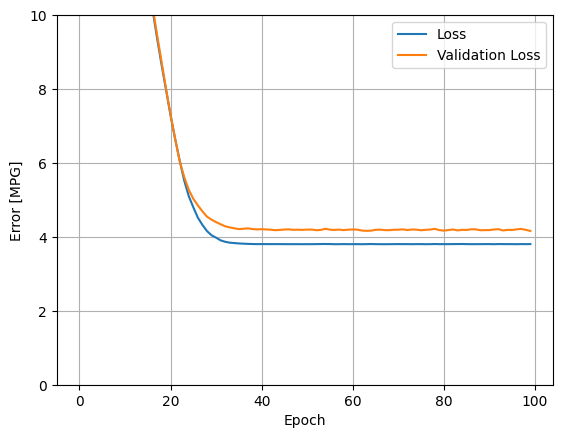

In [169]:
plot_loss(history)

In [170]:
result = horsepower_model.evaluate(
    test_features["Horsepower"],
    test_labels,
    verbose=0)

test_results = {
    "horsepower_model": result
}

In [171]:
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [172]:
def plot_horsepower(x, y):
  plt.scatter(train_features["Horsepower"], train_labels, label="Data")
  plt.plot(x, y, color="k", label="Predictions")
  plt.xlabel("Horsepower")
  plt.ylabel("MPG")
  plt.legend()

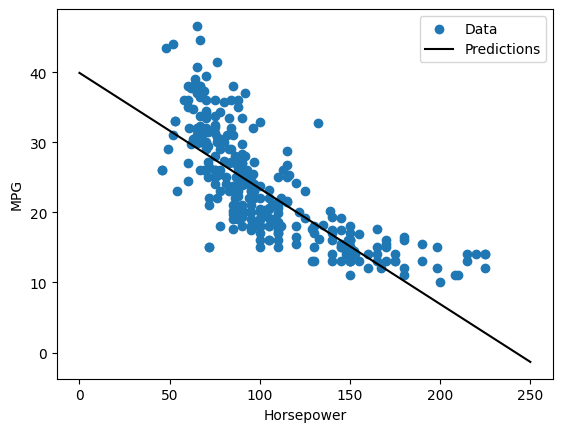

In [173]:
plot_horsepower(x, y)

## Linear regression with multiple inputs

In [174]:
linear_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(units=1)
])

In [175]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [176]:
%%time
history = linear_model.fit(
    train_features,
    train_labels,
    epochs=100,
    verbose=0,
    validation_split = 0.2)

CPU times: user 4.42 s, sys: 1.12 s, total: 5.54 s
Wall time: 4.31 s


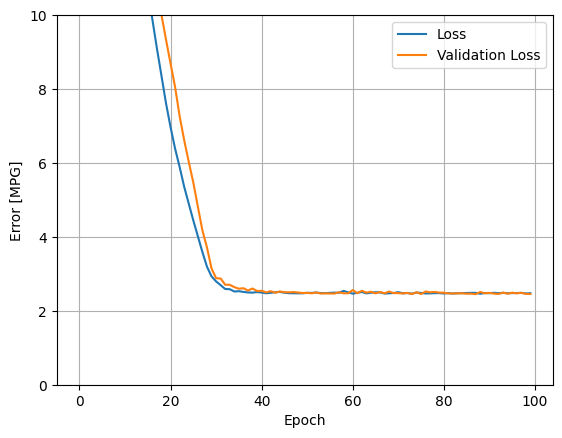

In [177]:
plot_loss(history)

In [179]:
result = linear_model.evaluate(
    test_features,
    test_labels,
    verbose=0)

test_results["linear_model"] = result

## Regression with DNN and a single input

In [180]:
dnn_horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [181]:
dnn_horsepower_model.compile(
    loss="mean_absolute_error",
    optimizer=tf.keras.optimizers.Adam(0.001))

In [182]:
%%time
history = dnn_horsepower_model.fit(
    train_features["Horsepower"],
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100)

CPU times: user 5.01 s, sys: 1.14 s, total: 6.15 s
Wall time: 5 s


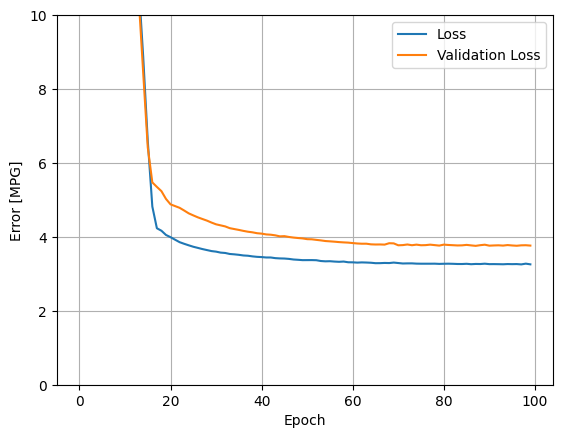

In [191]:
plot_loss(history)

In [192]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


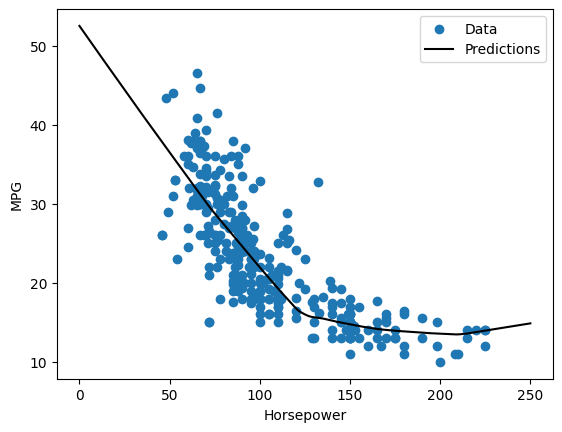

In [193]:
plot_horsepower(x, y)

In [194]:
result = dnn_horsepower_model.evaluate(
    test_features["Horsepower"],
    test_labels,
    verbose=0)

test_results["dnn_horsepower_model"] = result

## Regression using a DNN and multiple inputs

In [195]:
dnn_model = tf.keras.Sequential([
    normalizer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1)
])

In [196]:
dnn_model.compile(
    loss="mean_absolute_error",
    optimizer=tf.keras.optimizers.Adam(0.001))

In [197]:
%%time
history = dnn_model.fit(
    train_features,
    train_labels,
    validation_split=0.2,
    verbose=0,
    epochs=100)

CPU times: user 5.04 s, sys: 1.18 s, total: 6.22 s
Wall time: 5.08 s


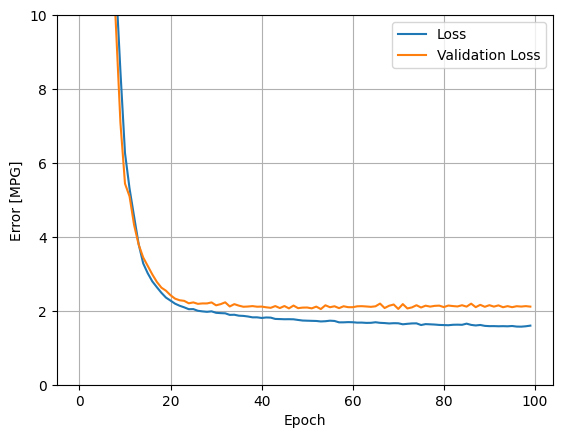

In [198]:
plot_loss(history)

In [199]:
result = dnn_model.evaluate(test_features, test_labels, verbose=0)

test_results["dnn_model"] = result

# Performance

In [200]:
pd.DataFrame(test_results, index=["Mean absolute error [MPG]"]).T

,Mean absolute error [MPG]
horsepower_model,3.648474
linear_model,2.486110
dnn_horsepower_model,2.914978
dnn_model,1.682377


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


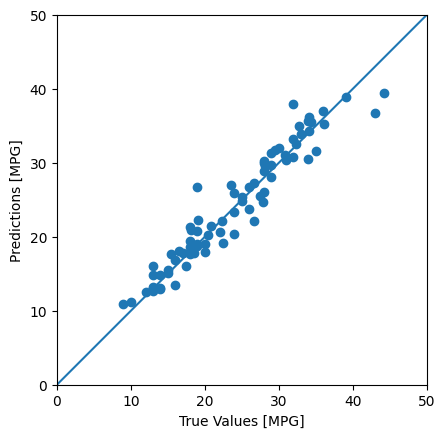

In [203]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect="equal")
plt.scatter(test_labels, test_predictions)
plt.xlabel("True Values [MPG]")
plt.ylabel("Predictions [MPG]")
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

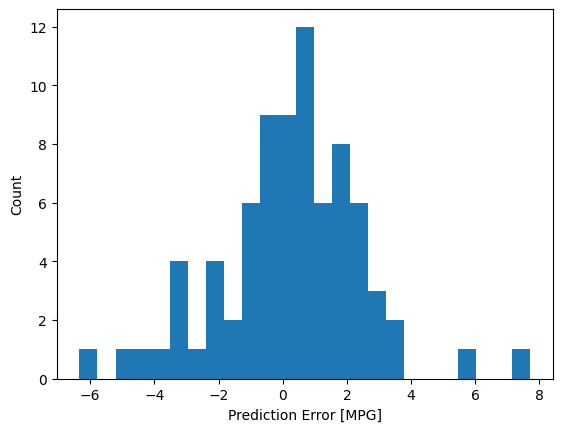

In [204]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel("Prediction Error [MPG]")
_ = plt.ylabel("Count")